**Import Libraries**

In [2]:
import pandas as pd
import numpy as np

**Load the Dataset**

In [3]:
df = pd.read_csv("online_retail_09_10.csv", encoding='ISO-8859-1')

**Check First 5 Rows**

In [4]:
df.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.0,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,12/1/2009 7:45,1.25,13085.0,United Kingdom


**Check Data Types**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174266 entries, 0 to 174265
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ï»¿InvoiceNo  174266 non-null  object 
 1   StockCode     174265 non-null  object 
 2   Description   172960 non-null  object 
 3   Quantity      174265 non-null  float64
 4   InvoiceDate   174265 non-null  object 
 5   UnitPrice     174265 non-null  float64
 6   CustomerID    132900 non-null  float64
 7   Country       174265 non-null  object 
dtypes: float64(3), object(5)
memory usage: 10.6+ MB


**Check Null Values**

In [6]:
df.isnull().sum()

,0
ï»¿InvoiceNo,0
StockCode,1
Description,1306
Quantity,1
InvoiceDate,1
UnitPrice,1
CustomerID,41366
Country,1


In [7]:
df.rename(columns={'ï»¿InvoiceNo': 'InvoiceNo'}, inplace=True)

In [8]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

**Data Cleaning**

**Remove Null CustomerID**

In [9]:
df = df.dropna(subset=['CustomerID'])

**Remove Cancelled Orders**

In [11]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

**Remove Negative or Zero Quantity**

In [12]:
df = df[df['Quantity'] > 0]

**Remove Remaining Null Values**

In [13]:
df = df.dropna()

In [14]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


**Convert InvoiceDate to Datetime**

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129420 entries, 0 to 174264
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    129420 non-null  object        
 1   StockCode    129420 non-null  object        
 2   Description  129420 non-null  object        
 3   Quantity     129420 non-null  float64       
 4   InvoiceDate  129420 non-null  datetime64[ns]
 5   UnitPrice    129420 non-null  float64       
 6   CustomerID   129420 non-null  float64       
 7   Country      129420 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 8.9+ MB


In [17]:
df['InvoiceDate'].head()

,InvoiceDate
0,2009-12-01 07:45:00
1,2009-12-01 07:45:00
2,2009-12-01 07:45:00
3,2009-12-01 07:45:00
4,2009-12-01 07:45:00


**Create TotalPrice Column**

In [19]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()

,Quantity,UnitPrice,TotalPrice
0,12.0,6.95,83.4
1,12.0,6.75,81.0
2,12.0,6.75,81.0
3,48.0,2.10,100.8
4,24.0,1.25,30.0


**Create Reference Date**

In [21]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date

Timestamp('2010-04-27 13:54:00')

**Calculate RFM Table**

In [23]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

**Rename Columns**

In [24]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [25]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,56,10,230.55
12358.0,140,1,1429.83
12359.0,35,4,1522.23
12360.0,34,2,158.00
12361.0,90,1,109.20


In [26]:
rfm.describe()

,Recency,Frequency,Monetary
count,2388.000000,2388.000000,2388.00000
mean,52.873116,2.597152,1217.69727
std,42.468592,3.989012,4755.20064
min,1.000000,1.000000,0.00000
25%,18.000000,1.000000,244.57250
50%,41.000000,1.000000,465.50500
75%,79.000000,3.000000,988.32500
max,147.000000,61.000000,129911.69000


**Create Recency Score**

Low Recency → Score 4 (Best)

High Recency → Score 1 (Worst)

In [32]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])

**Create Frequency Score**

High Frequency → Score 4

In [29]:
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'),
                         4,
                         labels=[1,2,3,4])

**Create Monetary Score**

High Spending → Score 4

In [33]:
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

**Convert Scores to Integer**

In [34]:
rfm[['R_Score','F_Score','M_Score']] = \
rfm[['R_Score','F_Score','M_Score']].astype(int)

In [35]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12346.0,56,10,230.55,2,4,1
12358.0,140,1,1429.83,1,1,4
12359.0,35,4,1522.23,3,4,4
12360.0,34,2,158.00,3,3,1
12361.0,90,1,109.20,1,1,1


**Create Combined RFM Score**

In [36]:
rfm['RF_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str)
rfm[['R_Score','F_Score','RF_Score']].head()

,R_Score,F_Score,RF_Score
CustomerID,,,
12346.0,2,4,24
12358.0,1,1,11
12359.0,3,4,34
12360.0,3,3,33
12361.0,1,1,11


**Assign Segment Labels**

Method: Rule-Based Segmentation

In [37]:
def segment_customer(row):

    if row['R_Score'] == 4 and row['F_Score'] == 4:
        return "Champions"

    elif row['F_Score'] >= 3:
        return "Loyal Customers"

    elif row['R_Score'] == 4 and row['F_Score'] <= 2:
        return "New Customers"

    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return "At Risk"

    elif row['R_Score'] == 1 and row['F_Score'] <= 2:
        return "Lost Customers"

    else:
        return "Potential Loyalists"

In [38]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

**Check Segment Distribution**

In [39]:
rfm['Segment'].value_counts()

,count
Segment,
Loyal Customers,896
Potential Loyalists,576
Lost Customers,468
Champions,298
New Customers,150


**Visualize Segment Counts**

In [40]:
import matplotlib.pyplot as plt
segment_counts = rfm['Segment'].value_counts()
segment_counts

,count
Segment,
Loyal Customers,896
Potential Loyalists,576
Lost Customers,468
Champions,298
New Customers,150


**Create Bar Chart**

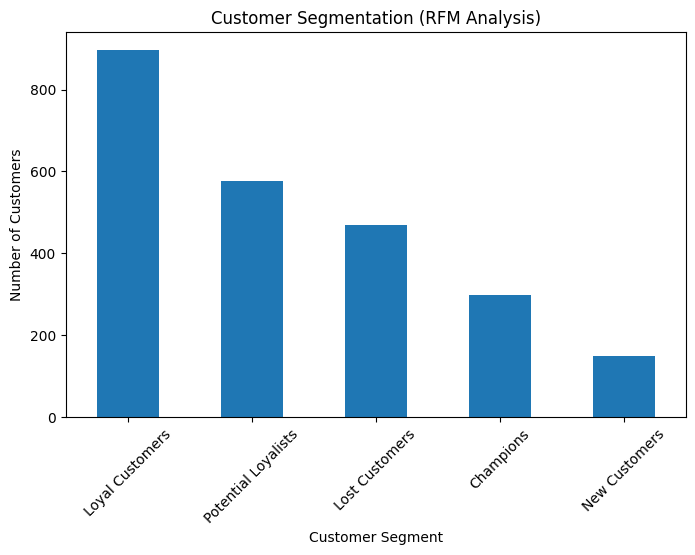

In [41]:
plt.figure(figsize=(8,5))
segment_counts.plot(kind='bar')

plt.title("Customer Segmentation (RFM Analysis)")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")

plt.xticks(rotation=45)
plt.show()

In [42]:
rfm.to_csv("Customer_Segmentation_RFM.csv")

**3 business actions**

**Champions -**

Give VIP rewards and exclusive offers

Upsell premium or high-value products

Encourage referrals and reviews

**Loyal Customers-**

Offer loyalty points or rewards

Send personalized product recommendations

Give bundle or repeat-purchase discounts

**Potential Loyalists-**

Send follow-up promotional emails

Offer limited-time discounts

Encourage membership or subscription